# Evaluierung

# Set up

In [ ]:
!pip install -q qdrant-client git+https://github.com/illuin-tech/colpali
!pip install -q ranx

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.1 which is incompatible.
tensorflow-meta

In [ ]:
!pip install -q ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00
time: 421 µs (started: 2024-12-06 09:49:42 +00:00)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from io import BytesIO
from qdrant_client import QdrantClient
from qdrant_client.http import models
from colpali_engine.models import ColQwen2, ColQwen2Processor
from IPython.display import display
from io import BytesIO
import base64
from PIL import Image
import torch
import cv2
import numpy as np
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm
import json
import os

def encode_base64_image(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return str(base64.b64encode(buffered.getvalue()), "utf-8")


def decode_base64_image(base64_string):
    # Decode the base64 string into bytes
    image_data = base64.b64decode(base64_string)

    # Convert the bytes back into an image
    buffered = BytesIO(image_data)
    image = Image.open(buffered)

    return image


def resize_image(image, max_height=800):
    width, height = image.size
    if height > max_height:
        ratio = max_height / height
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        return image.resize((new_width, new_height))
    return image


def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def combine_json_files(directory: str):
    combined_data = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            data = load_json(file_path)
            combined_data.extend(data)

    return combined_data

In [ ]:
# coding=utf-8
# Copyright 2024 The GTE Team Authors and Alibaba Group.
# Licensed under the Apache License, Version 2.0 (the "License");

from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers.utils import is_torch_npu_available


class GTEEmbeddidng(torch.nn.Module):
    def __init__(self,
                 model_name: str = None,
                 normalized: bool = True,
                 use_fp16: bool = True,
                 device: str = None
                ):
        super().__init__()
        self.normalized = normalized
        if device:
            self.device = torch.device(device)
        else:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif is_torch_npu_available():
                self.device = torch.device("npu")
            else:
                self.device = torch.device("cpu")
                use_fp16 = False
        self.use_fp16 = use_fp16
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(
            model_name, trust_remote_code=True, torch_dtype=torch.float16 if self.use_fp16 else None
        )
        self.vocab_size = self.model.config.vocab_size
        self.model.to(self.device)

    def _process_token_weights(self, token_weights: np.ndarray, input_ids: list):
        result = defaultdict(int)
        unused_tokens = {self.tokenizer.cls_token_id, self.tokenizer.eos_token_id,
                        self.tokenizer.pad_token_id, self.tokenizer.unk_token_id}

        for w, idx in zip(token_weights, input_ids):
            idx = int(idx)
            if idx not in unused_tokens and w > 0:
                if w > result[idx]:
                    result[idx] = w
        return {
            "values": list(result.values()),
            "indices": list(result.keys())
        }

    @torch.no_grad()
    def encode(self,
               texts: None,
               dimension: int = None,
               max_length: int = 8192,
               batch_size: int = 16,
               return_dense: bool = True,
               return_sparse: bool = False):
        if dimension is None:
            dimension = self.model.config.hidden_size
        if isinstance(texts, str):
            texts = [texts]
        num_texts = len(texts)
        all_dense_vecs = []
        all_token_weights = []
        for n, i in enumerate(range(0, num_texts, batch_size)):
            batch = texts[i: i + batch_size]
            results = self._encode(batch, dimension, max_length, batch_size, return_dense, return_sparse)
            if return_dense:
                all_dense_vecs.append(results['dense_embeddings'])
            if return_sparse:
                all_token_weights.extend(results['token_weights'])
        if return_dense:
            all_dense_vecs = torch.cat(all_dense_vecs, dim=0)

        return {
            "dense_embeddings": all_dense_vecs if return_dense else None,
            "token_weights": all_token_weights if return_sparse else None
        }

    @torch.no_grad()
    def _encode(self,
                texts: Dict[str, torch.Tensor] = None,
                dimension: int = None,
                max_length: int = 1024,
                batch_size: int = 16,
                return_dense: bool = True,
                return_sparse: bool = False):

        text_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
        text_input = {k: v.to(self.model.device) for k,v in text_input.items()}
        model_out = self.model(**text_input, return_dict=True)

        output = {}
        if return_dense:
            dense_vecs = model_out.last_hidden_state[:, 0, :dimension]
            if self.normalized:
                dense_vecs = torch.nn.functional.normalize(dense_vecs, dim=-1)
            output['dense_embeddings'] = dense_vecs
        if return_sparse:
            token_weights = torch.relu(model_out.logits).squeeze(-1)
            token_weights = [
                self._process_token_weights(weights, input_ids)
                for weights, input_ids in zip(
                    token_weights.detach().cpu().numpy().tolist(),
                    text_input['input_ids'].cpu().numpy().tolist()
                )
            ]
            output['token_weights'] = token_weights

        return output

    def _compute_sparse_scores(self, emb1, emb2):
        scores = 0
        emb2_lookup = {idx: val for idx, val in zip(emb2["indices"], emb2["values"])}
        for idx, weight in zip(emb1["indices"], emb1["values"]):
            if idx in emb2_lookup:
                scores += weight * emb2_lookup[idx]
        return scores

    def compute_sparse_scores(self, embs1, embs2):
        scores = [self._compute_sparse_scores(emb1, emb2) for emb1, emb2 in zip(embs1, embs2)]
        return np.array(scores)

    def compute_dense_scores(self, embs1, embs2):
        scores = torch.sum(embs1*embs2, dim=-1).cpu().detach().numpy()
        return scores

    @torch.no_grad()
    def compute_scores(self,
        text_pairs: List[Tuple[str, str]],
        dimension: int = None,
        max_length: int = 1024,
        batch_size: int = 16,
        dense_weight=1.0,
        sparse_weight=0.1):
        text1_list = [text_pair[0] for text_pair in text_pairs]
        text2_list = [text_pair[1] for text_pair in text_pairs]
        embs1 = self.encode(text1_list, dimension, max_length, batch_size, return_dense=True, return_sparse=True)
        embs2 = self.encode(text2_list, dimension, max_length, batch_size, return_dense=True, return_sparse=True)
        scores = self.compute_dense_scores(embs1['dense_embeddings'], embs2['dense_embeddings']) * dense_weight + \
            self.compute_sparse_scores(embs1['token_weights'], embs2['token_weights']) * sparse_weight
        scores = scores.tolist()
        return scores

model_name_or_path = 'Alibaba-NLP/gte-multilingual-base'
sparse_dense_model = GTEEmbeddidng(model_name_or_path)

time: 2.78 s (started: 2024-12-06 09:52:12 +00:00)


In [ ]:
vision_model = ColQwen2.from_pretrained(
        "vidore/colqwen2-v1.0",
        torch_dtype=torch.bfloat16,
        device_map="cuda",  # or "cpu"
    ).eval()
processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v1.0")

adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
apikey_chunks = ""
collection_chunks = "chunked-and-embedded-manuals"
apikey_pages = ""
collection_pages = "embedded-manuals"

client_chunks = QdrantClient(
     url="https://c1c6b76d-3e82-4265-8850-542922eeb4b9.us-east4-0.gcp.cloud.qdrant.io:6333/dashboard#/collections",
     api_key=apikey_chunks,
 )
client_pages = QdrantClient(
    url="https://568e9069-f3eb-4ee2-8e22-52e7bad7d3b7.europe-west3-0.gcp.cloud.qdrant.io:6333",
    api_key=apikey_pages,
)

In [ ]:
client_pages.get_collection(collection_name="embedded-manuals")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=3234, points_count=1078, segments_count=4, config=CollectionConfig(params=CollectionParams(vectors={'dense': VectorParams(size=768, distance=<Distance.DOT: 'Dot'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'multi': VectorParams(size=128, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>))}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors={'sparse': SparseVectorParams(index=SparseIndexParams(full_scan_threshold=None, on_disk=False, datatype=None), modifier=None)}), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10

time: 529 ms (started: 2024-11-28 09:42:21 +00:00)


# Query loading and preprocessing

Building Ground Truth

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Evaluation/Testfragen(Fragen).csv", delimiter =";", encoding="latin1")
#df = pd.read_csv("Testfragen.csv", encoding="utf-8", delimiter =";")

In [ ]:
queries_same_language = df[df["Language"].astype(str) == df["Document Language"].astype(str)]
queries_precise = queries_same_language[queries_same_language["Type"].astype(str) == "Precise"]
queries_ambigious = queries_same_language[queries_same_language["Type"].astype(str) == "Ambigious"]
queries_ultraprecise = queries_same_language[queries_same_language["Type"].astype(str) == "Ultraprecise"]
queries_english = queries_same_language[queries_same_language["Document Language"].astype(str) == "en"]
queries_german = queries_same_language[queries_same_language["Document Language"].astype(str) == "de"]

queries_f_EN_d_EN = df[df["Language"].astype(str) == "en" & df["Document Language"].astype(str) == "en"]
queries_f_EN_d_EN_precise = queries_f_EN_d_EN[queries_f_EN_d_EN["Type"].astype(str) == "Precise"]
queries_f_EN_d_EN_ambigious = queries_f_EN_d_EN[queries_f_EN_d_EN["Type"].astype(str) == "Ambigious"]

print(len(queries_f_EN_d_EN), len(queries_f_EN_d_EN_precise), len(queries_f_EN_d_EN_ambigious))

queries_f_DE_d_BOTH = df[df["Language"].astype(str) == "de" & (df["Document Language"].astype(str) == "en" | df["Document Language"].astype(str) == "de")]
queries_f_DE_d_BOTH_precise = queries_f_DE_d_BOTH[queries_f_DE_d_BOTH["Type"].astype(str) == "Precise"]
queries_f_DE_d_BOTH_ambigious = queries_f_DE_d_BOTH[queries_f_DE_d_BOTH["Type"].astype(str) == "Ambigious"]

print(len(queries_f_DE_d_BOTH), len(queries_f_DE_d_BOTH_precise), len(queries_f_DE_d_BOTH_ambigious))

queries_f_DEtranslEN_d_BOTH = df[df["Language"].astype(str) == "detranslEN" & (df["Document Language"].astype(str) == "en" | df["Document Language"].astype(str) == "de")]
queries_f_DEtranslEN_d_BOTH_precise = queries_f_DEtranslEN_d_BOTH[queries_f_DEtranslEN_d_BOTH["Type"].astype(str) == "Precise"]
queries_f_DEtranslEN_d_BOTH_ambigious = queries_f_DEtranslEN_d_BOTH[queries_f_DEtranslEN_d_BOTH["Type"].astype(str) == "Ambigious"]

print(len(queries_f_DEtranslEN_d_BOTH), len(queries_f_DEtranslEN_d_BOTH_precise), len(queries_f_DEtranslEN_d_BOTH_ambigious))

len(queries_german), len(queries_english)

In [ ]:
queries = queries_same_language

In [ ]:
import json

with open("/content/drive/MyDrive/Evaluation/pages-ids (2).json", "r") as file:
     data = json.load(file)

#with open("pages-ids.json", "r") as file:
#    data = json.load(file)

def get_id_by_title_and_page(title, page_number):
    for item in data:
        if item['title'] == title and item['page_number'] == page_number:
            return item['id']
    return None

In [ ]:
from ranx import Qrels
from collections import defaultdict

qrels_dict = defaultdict(dict)
queries_lookup = dict()

for _, row in queries.iterrows():
      query_id = str(row["ID"])
      document_name = str(row["Relevant Document"])
      optimal_page = row["Optimal Page"]

      page_id = get_id_by_title_and_page(document_name, optimal_page)

      queries_lookup[query_id] = (str(row["Question"]),page_id)
      if page_id is None:
        break

      score = 1
      qrels_dict[str(query_id)][str(page_id)] = score

qrels = Qrels(qrels_dict, name=collection_pages)

del queries_lookup['nan']
queries_lookup, qrels

({'1.0': ('Wo finde ich die Ladepole an der MiR Charge 24V-Ladestation?', 749),
  '2.0': ('Wo befinden sich die Stecker für die Charging Station?', 749),
  '3.0': ('Wo sind die Kontakte zum Laden über die Dockingstation?', 749),
  '7.0': ('Welche ersten Schritte sind notwendig zur Inbetriebnahme?', 769),
  '8.0': ('Ich habe den Roboter neu bekommen. Was muss ich jetzt tun?', 769),
  '9.0': ('Wie muss ich den Roboter erstmalig aufsetzen, sodass ich ihn benutzen kann?',
   769),
  '13.0': ('Wie erstelle ich Benutzergruppen und Benutzer?', 855),
  '14.0': ('Wie kann ich mir in der Roboter Software einen Account erstellen?',
   855),
  '15.0': ('Ich muss einen Account in der Software erstellen. Wie mache ich das?',
   855),
  '19.0': ('Wie kann ich MiR200 Aufsatzmodule anbringen?', 894),
  '20.0': ('Ich habe ein Fließband und möchte das auf dem Roboter anbringen. Wie?',
   894),
  '21.0': ('Wie kann ich weitere Bauteile auf dem Roboter befestigen?', 894),
  '25.0': ('Wie hoch darf der Gege

time: 113 ms (started: 2024-12-06 10:19:42 +00:00)


Embedding der Queries

In [ ]:
from tqdm import tqdm

sparse_vectors = []
dense_vectors = []
multi_vectors = []

# Calculate number of batches
batch_size = 5
n_samples = len(queries)
n_batches = (n_samples + batch_size - 1) // batch_size

# Process in batches
for batch_idx in tqdm(range(n_batches)):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, n_samples)

    # Get batch of queries
    batch_queries = queries.iloc[start_idx:end_idx]["Question"].astype(str).tolist()

    # Generate sparse and dense vectors for batch
    batch_vectors = sparse_dense_model.encode(
        batch_queries,
        return_sparse=True,
        return_dense=True
    )

    # Process sparse vectors
    sparse_vectors.extend(batch_vectors["token_weights"])

    # Process dense vectors - simplified to handle flat structure
    batch_dense = [embed.tolist() for embed in batch_vectors["dense_embeddings"]]
    dense_vectors.extend(batch_dense)

    # Generate multi vectors
    with torch.no_grad():
        batch_query = processor.process_queries(batch_queries).to(vision_model.device)
        batch_embeddings = vision_model(**batch_query)
        multi_vectors.extend(
            batch_embeddings.cpu().float().tolist()
        )


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


In [ ]:
import torch
from typing import Dict, List, Union

def embed_single_query(
    query: str
) -> Dict[str, Union[List[float], List[List[float]]]]:
    """
    Embed a single query using sparse-dense and vision models.

    Args:
        query (str): The query text to embed
        sparse_dense_model: Model for generating sparse and dense embeddings
        vision_model: Vision model for generating multi-modal embeddings
        processor: Processor for preparing queries for vision model

    Returns:
        Dict containing:
            - sparse_vector: Sparse embedding weights
            - dense_vector: Dense embedding vector
            - multi_vector: Multi-modal embedding vector
    """
    # Generate sparse and dense vectors
    vectors = sparse_dense_model.encode(
        [query],  # Wrap single query in list
        return_sparse=True,
        return_dense=True
    )

    # Extract sparse and dense vectors
    sparse_vector = vectors["token_weights"][0]  # Get first (only) item
    dense_vector = vectors["dense_embeddings"][0].tolist()  # Convert to list

    # Generate multi-modal vector
    with torch.no_grad():
        query_input = processor.process_queries([query]).to(vision_model.device)
        embeddings = vision_model(**query_input)
        multi_vector = embeddings.cpu().float().tolist()[0]  # Get first (only) item

    return {
        "sparse_vector": sparse_vector,
        "dense_vector": dense_vector,
        "multi_vector": multi_vector
    }

# Code for evaluation

In [ ]:
from openai import OpenAI

client_openai = OpenAI(api_key="")

evaluation_prompt = """You are an expert evaluator for image retrieval systems. Your task is to assess whether a given user query can be answered using the provided images.

For each query, carefully analyze the provided images and determine if they contain sufficient information to answer the query. Score the relevance as follows:

- Score 0: Query cannot be answered at all using these images
- Score 0.5: Images contain partially relevant information that could be helpful but don't fully answer the query
- Score 1: Query can be fully answered using these images

Examine the visual content, text, and context in each image thoroughly before making your assessment.

Output your evaluation in JSON format like this:
{
  "score": <value>
}

where <value> is 0, 0.5, or 1 based on your assessment.

Think step-by-step:
1. Understand the user's query requirements
2. Analyze each image's content and relevance
3. Determine if the images collectively provide:
   - No relevant information (0)
   - Partially relevant/helpful information (0.5)
   - Complete information to answer the query (1)
4. Output the score in the required JSON format

Before providing the score, briefly explain your reasoning to ensure transparency in your evaluation process."""


TypeError: Client.__init__() got an unexpected keyword argument 'proxies'

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Iterator, Tuple
from ranx import Run, evaluate, compare
from qdrant_client import models
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets

@dataclass
class QueryVector:
    dense: Any
    sparse: dict
    multi: Any
    query_id: str

@dataclass
class RunWithPayloads:
    run: Run
    payloads: Dict[str, List[Dict[str, Any]]]
    llm_evaluation: Optional[Dict[str, float]] = None

class Engine:
    def __init__(self, client, collection, queries: Dict[str, Tuple[str, str]], qrels, metrics=None, chunked=False):
        self.client = client
        self.collection = collection
        self.queries = queries  # New structure: {query_id: (text, solution_id)}
        self.qrels = qrels
        self.metrics = metrics or ["precision@1", "hit_rate@5", "mrr@5"]
        self.runs: Dict[str, RunWithPayloads] = {}
        self.chunked = chunked

    def create_run(self, name: str, run_dict: Dict[str, Dict[str, float]], payloads_dict: Dict[str, List[Dict[str, Any]]]) -> RunWithPayloads:
        """Create and store a Run object with given name, results, and payloads"""
        run = Run(run_dict, name=name)
        run_with_payloads = RunWithPayloads(run=run, payloads=payloads_dict)
        self.runs[name] = run_with_payloads
        return run_with_payloads

    def evaluate_run(self, run_name: str, llm = True, top_k = 5) -> float:
        """Evaluate a single run with an llm and return accuracy"""
        if (llm):
            run_with_payloads = self.runs[run_name]
            eval = {}
            score_sum, zeros, halfs, ones = 0, 0, 0, 0
            for query_id, payloads in tqdm(run_with_payloads.payloads.items(), total=len(run_with_payloads.payloads)):
                messages = [{
                        "role": "user",
                        "content": []
                    }]
                for payload in payloads[:top_k]:
                    image_url = "data:image/jpeg;base64," + payload["image"]
                    messages[0]["content"].append({
                        "type": "image_url",
                        "image_url": {
                            "url": image_url
                        }
                    })

                messages[0]["content"].append({
                    "type": "text",
                    "text": evaluation_prompt
                })
                llm_response = client_openai.chat.completions.create(
                        model="gpt-4o",
                        messages=messages,
                        response_format={"type": "json_object"})

                score = json.loads(llm_response.choices[0].message.content)["score"]
                score_sum += score
                if score == 0:
                    zeros += 1
                elif score == 0.5:
                    halfs += 1
                elif score == 1:
                    ones += 1
                eval[query_id] = score

            run_with_payloads.llm_evaluation = eval
            print("")
            print(f"Accuracy: {score_sum / len(run_with_payloads.run)}")
            print(f"Zeros: {zeros}")
            print(f"Halfs: {halfs}")
            print(f"Ones: {ones}")

            return score_sum / len(run_with_payloads.run)


        #else:
        #    return evaluate(self.qrels, run_with_payloads.run, metrics=self.metrics, make_comparable=True)

    def compare_runs(self, run_names: Optional[List[str]] = None) -> str:
        """Compare specified runs or all runs if none specified"""
        runs_to_compare = [self.runs[name].run for name in (run_names or self.runs.keys())]
        return compare(
            qrels=self.qrels,
            runs=runs_to_compare,
            metrics=self.metrics,
            rounding_digits=3,
            show_percentages=True,
            make_comparable=True
        )

    def basic_search_run(self, query_vectors: List[QueryVector], using: str, name: str, final_limit: int = 5) -> RunWithPayloads:
        """Performs a run with simple search"""
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:

            scores_dict, query_payloads = self.basic_search(qv, using, final_limit)

            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def basic_search(self, qv: QueryVector, using: str, final_limit: int = 5):
        """Perform basic search using a single vector type"""
        query_vector = self._get_query_vector(qv, using)
        results = self.client.query_points(
            self.collection,
            query=query_vector,
            using=using,
            with_payload=True,
            limit=final_limit
            )

        if self.chunked:
            seen_ids = set()
            scores_dict = {}
            query_payloads = []

            for point in results.points:
                point_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))
                if point_id not in seen_ids:
                    scores_dict[point_id] = point.score
                    query_payloads.append(point.payload)
                    seen_ids.add(point_id)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
        return scores_dict, query_payloads

    def rrf_fusion_search_run(
        self,
        query_vectors: List[QueryVector],
        methods: List[str],
        name: str,
        prefetch_limit: int = 50,
        final_limit: int = 5
    ) -> RunWithPayloads:
        """Performs a run with rrf fusion search"""
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.rrf_fusion_search(qv, methods, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def rrf_fusion_search(self, qv: QueryVector, methods: List[str], prefetch_limit: int = 50, final_limit: int = 5):
        """Perform Reciprocal Rank Fusion search using multiple methods"""
        prefetch = [
                models.Prefetch(
                    query=self._get_query_vector(qv, method),
                    using=method,
                    limit=prefetch_limit
                )
                for method in methods
            ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            query=models.FusionQuery(fusion=models.Fusion.RRF),
            with_payload=True,
            limit=final_limit,
        )

        if self.chunked:
            seen_ids = set()
            scores_dict = {}
            query_payloads = []

            for point in results.points:
                point_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))
                if point_id not in seen_ids:
                    scores_dict[point_id] = point.score
                    query_payloads.append(point.payload)
                    seen_ids.add(point_id)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
        return scores_dict, query_payloads


    def reranking_search_run(
        self,
        query_vectors: List[QueryVector],
        prefetch_method: str,
        rerank_method: str,
        name: str,
        prefetch_limit: int = 30,
        final_limit: int = 5
    ) -> RunWithPayloads:
        """Perform a run with reranking search"""
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.reranking_search(qv, prefetch_method, rerank_method, prefetch_limit, final_limit)
            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def reranking_search(self, qv: QueryVector, prefetch_method: str, rerank_method: str,prefetch_limit: int = 30, final_limit: int = 5):
        """Perform reranking search using a single method"""
        prefetch = [
                models.Prefetch(
                    query=self._get_query_vector(qv, prefetch_method),
                    using=prefetch_method,
                    limit=prefetch_limit
                )
            ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            using=rerank_method,
            query=self._get_query_vector(qv, rerank_method),
            with_payload=True,
            limit=final_limit,
        )

        if self.chunked:
            seen_ids = set()
            scores_dict = {}
            query_payloads = []

            for point in results.points:
                point_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))
                if point_id not in seen_ids:
                    scores_dict[point_id] = point.score
                    query_payloads.append(point.payload)
                    seen_ids.add(point_id)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
        return scores_dict, query_payloads


    def nested_prefetch_search_run(
        self,
        query_vectors: List[QueryVector],
        primary_method: str,
        secondary_prefetch_methods: List[str],
        name: str,
        primary_limit: int = 20,
        secondary_limit: int = 50,
        final_limit: int = 5
    ) -> RunWithPayloads:
        """Perform a run with nested prefetch structure"""
        run_dict = {}
        payloads_dict = {}

        for qv in query_vectors:
            scores_dict, query_payloads = self.nested_prefetch_search(qv, primary_method, secondary_prefetch_methods, primary_limit, secondary_limit, final_limit)

            run_dict[qv.query_id] = scores_dict
            payloads_dict[qv.query_id] = query_payloads

        return self.create_run(name, run_dict, payloads_dict)

    def nested_prefetch_search(self, qv: QueryVector, primary_method: str, secondary_prefetch_methods: List[str], primary_limit: int = 20, secondary_limit: int = 50, final_limit: int = 5):
        """Perform nested prefetch search"""
        inner_prefetch = [
                models.Prefetch(
                    query=self._get_query_vector(qv, method),
                    using=method,
                    limit=secondary_limit
                )
                for method in secondary_prefetch_methods
            ]

        prefetch = [
            models.Prefetch(
                prefetch=inner_prefetch,
                query=self._get_query_vector(qv, primary_method),
                using=primary_method,
                limit=primary_limit
            )
        ]

        results = self.client.query_points(
            self.collection,
            prefetch=prefetch,
            query=self._get_query_vector(qv, "multi"),
            using="multi",
            with_payload=True,
            limit=final_limit
        )

        if self.chunked:
            seen_ids = set()
            scores_dict = {}
            query_payloads = []

            for point in results.points:
                point_id = str(get_id_by_title_and_page(point.payload["title"], point.payload["page_number"]))
                if point_id not in seen_ids:
                    scores_dict[point_id] = point.score
                    query_payloads.append(point.payload)
                    seen_ids.add(point_id)
        else:
            scores_dict = {str(point.id): point.score for point in results.points}
            query_payloads = [point.payload for point in results.points]
        return scores_dict, query_payloads


    def _get_query_vector(self, query_vector: QueryVector, method: str) -> Any:
        """Get the appropriate vector based on the method"""
        if method == "dense":
            return query_vector.dense
        elif method == "sparse":
            return models.SparseVector(**query_vector.sparse)
        elif method == "multi":
            return query_vector.multi
        else:
            raise ValueError(f"Unknown method: {method}")

    def inspect_run(self, run_name: str, top_k = 5) -> None:
        """
        Interactive inspection of search results using IPython widgets.
        Uses saved payloads instead of making client calls.

        Args:
            run_name: Name of the run to inspect
        """

        run_with_payloads = self.runs[run_name]
        queries_iterator = self._get_queries_iterator()

        # Pre-fetch and cache all required database entries
        all_correct_ids = {int(correct_id) for _, (_, correct_id) in queries_iterator}
        id_to_db_entry = {
            entry.id: entry
            for entry in client_pages.retrieve(collection_pages, list(all_correct_ids))
        }

        # Reset iterator after pre-fetching
        queries_iterator = self._get_queries_iterator()

        def display_results() -> None:
            clear_output(wait=True)
            display(next_button)

            query_id, (query_text, correct_id) = next(queries_iterator)
            display(HTML(f'<div style="margin: 10px 0;"><strong>Query:</strong> {query_text}</div>'))

            # Display correct page info
            correct_id = int(correct_id)
            db_entry = id_to_db_entry[correct_id]
            is_relevant = str(correct_id) in run_with_payloads.run[query_id]
            llm_score = run_with_payloads.llm_evaluation[query_id] if run_with_payloads.llm_evaluation else "-"

            html_output = ['<div style="margin: 20px 0;">']
            html_output.append('<h3>Correct Page:</h3>')
            # Display correct page with its image inline
            if "image" in db_entry.payload:
                correct_page_html = '<div style="display: flex; min-height: 60vh; align-items: center;">'
                img_data = db_entry.payload["image"]
                correct_page_html += f'''
                    <div style="flex: 0 0 400px;">
                        <img src="data:image/jpeg;base64,{img_data}" style="max-width: 400px; height: auto;"/>
                    </div>
                    <div style="flex: 1; align-self: flex-start; padding-top: 20px; margin-left: 20px;">
                        <p><strong>Relevant page retrieved:</strong> {is_relevant}</p>
                        <p><strong>LLM-score:</strong> {llm_score}</p>
                    </div>
                '''
                correct_page_html += '</div>'
                html_output.append(correct_page_html)

            # Display search results
            html_output.append('<h3>Search Results:</h3>')
            for doc_payload in run_with_payloads.payloads[query_id][:top_k]:
                html_output.append(create_result_html(doc_payload))

            display(HTML('\n'.join(html_output)))



        next_button = widgets.Button(description='Next Query')
        next_button.on_click(lambda _: display_results())
        display_results()

    def _get_queries_iterator(self) -> Iterator[Tuple[str, Tuple[str, str]]]:
        """Get iterator over queries with their IDs and correct answers"""
        return iter(self.queries.items())

def prepare_query_vectors(
    queries: Dict[str, Tuple[str, str]],
    dense_vectors: List[Any],
    sparse_vectors: List[dict],
    multi_vectors: List[Any]
) -> List[QueryVector]:
    """Prepare query vectors from different sources"""
    return [
        QueryVector(
            dense=dense_vectors[i],
            sparse=sparse_vectors[i],
            multi=multi_vectors[i],
            query_id=query_id
        )
        for i, (query_id, _) in enumerate(queries.items())
    ]

def compare_runs_from_multiple_engines(engines: List[Engine], metrics: List[str] = None) -> str:
    """Compare runs from multiple engines"""
    # if not specified just use the metrics from first engine
    if (not metrics):
        metrics = engines[0].metrics
    # should be the same for each engine anyway, otherwise peaches with apple
    qrels = engines[0].qrels

    seen_names=set()
    runs_to_compare = []
    for engine in engines:
        for name in engine.runs.keys():
            if name in seen_names:
                raise ValueError(f"Duplicate run name found: '{name}'. All run names must be unique across engines.")
            seen_names.add(name)
            runs_to_compare.append(engine.runs[name].run)

    return compare(
            qrels=qrels,
            runs=runs_to_compare,
            metrics=metrics,
            rounding_digits=3,
            show_percentages=True,
        )


def display_result(query_text, query_payloads, top_k=5) -> None:
    """Display search results for a given query"""
    display(HTML(f'<div style="margin: 10px 0;"><strong>Query:</strong> {query_text}</div>'))
    html_output = ['<div style="margin: 20px 0;">']

    # Display search results
    html_output.append('<h3>Search Results:</h3>')
    for doc_payload in query_payloads[:top_k]:
        html_output.append(create_result_html(doc_payload))

    display(HTML('\n'.join(html_output)))

def create_result_html(doc_payload):
    """Helper function to create HTML for a single result with inline image"""
    # Base styles including heading tree styles
    styles = '''
        <style>
            .path {
                font-family: system-ui;
                line-height: 1.5;
                margin: 10px 0;
            }
            .path-item {
                margin-left: 20px;
            }
            .path-arrow {
                color: #666;
                margin: 0 8px;
            }
        </style>
    '''

    html = styles + '<div style="display: flex; align-items: start; margin-bottom: 20px; border-bottom: 1px solid #ccc; padding-bottom: 20px;">'

    # Image column (left)
    if "image" in doc_payload:
        img_data = doc_payload["image"]
        html += f'''
            <div style="flex: 0 0 400px;">
                <img src="data:image/jpeg;base64,{img_data}" style="max-width: 400px; height: auto;"/>
            </div>
        '''

    # Text column (right)
    html += '<div style="flex: 1; margin-left: 20px;">'
    if "label" in doc_payload:
        html += f'<p><strong>Label:</strong> {doc_payload["label"]}</p>'
    if "title" in doc_payload:
        html += f'<p><strong>Title:</strong> {doc_payload["title"]}</p>'
    if "page_number" in doc_payload:
        html += f'<p><strong>Page:</strong> {doc_payload["page_number"]}</p>'
    if "headings" in doc_payload:
        headings = doc_payload["headings"]
        html += '<p><strong>Headings:</strong></p>'
        html += '<div class="path">'
        current_level = -1
        open_divs = 0
        for title, level in headings:
            while current_level >= level:
                html += '</div>'
                open_divs -= 1
                current_level -= 1
            if level > 0:
                html += '<div class="path-item">'
                html += f'<span class="path-arrow">-></span>'
                open_divs += 1
            html += f'<span>{title}</span>'
            current_level = level
        html += '</div>' * open_divs
        html += '</div>'
    html += '</div>'

    html += '</div>'

    return html

# Usage

## Pages collection

In [ ]:
# Initialize the engine
engine_pages = Engine(
    client=client_pages,
    collection=collection_pages,
    queries=queries_lookup,
    qrels=qrels
)

# Prepare query vectors
query_vectors_pages = prepare_query_vectors(
    queries=queries_lookup,
    dense_vectors=dense_vectors,
    sparse_vectors=sparse_vectors,
    multi_vectors=multi_vectors
)

# Basic searches
engine_pages.basic_search_run(query_vectors_pages, using="sparse", name="Sparse")
engine_pages.basic_search_run(query_vectors_pages, using="dense", name="Dense")
engine_pages.basic_search_run(query_vectors_pages, using="multi", name="Late Interaction")

# RRF fusion searches
engine_pages.rrf_fusion_search_run(
    query_vectors_pages,
    methods=["dense", "sparse"],
    name="Dense & Sparse(RRF)"
)

engine_pages.rrf_fusion_search_run(
    query_vectors_pages,
    methods=["multi", "sparse"],
    name="Late & Sparse(RRF)"
)

engine_pages.rrf_fusion_search_run(
    query_vectors_pages,
    methods=["multi", "dense", "sparse"],
    name="Sparse, Dense & Late (RRF)"
)

# Reranking searches
engine_pages.reranking_search_run(
    query_vectors_pages,
    prefetch_method="dense",
    rerank_method="sparse",
    name="Dense & Sparse(Reranker)"
)

# Nested prefetch search
engine_pages.nested_prefetch_search_run(
    query_vectors_pages,
    primary_method="dense",
    secondary_prefetch_methods=["sparse"],
    name="Sparse & Dense(Reranker) & Late Interaction(Reranker)"
)

# Compare all runs
report = engine_pages.compare_runs()
print(report)

#    Model                                                    P@1    Hit Rate@5    MRR@5
---  -----------------------------------------------------  -----  ------------  -------
a    Sparse                                                  27.7          40.4     32.7
b    Dense                                                   25.5          40.4     31
c    Late Interaction                                        34            44.7     38.1
d    Dense & Sparse(RRF)                                     27.7          48.9     35.1
e    Late & Sparse(RRF)                                      29.8          44.7     35.8
f    Sparse, Dense & Late (RRF)                              31.9          46.8     37.9
g    Dense & Sparse(Reranker)                                29.8          42.6     34.3
h    Sparse & Dense(Reranker) & Late Interaction(Reranker)   34            44.7     38.7


## Chunks collection

In [ ]:
# Initialize the engine
engine_chunks = Engine(
    client=client_chunks,
    collection=collection_chunks,
    queries=queries_lookup,
    qrels=qrels,
    chunked=True
)

# Prepare query vectors
query_vectors_chunks = prepare_query_vectors(
    queries=queries_lookup,
    dense_vectors=dense_vectors,
    sparse_vectors=sparse_vectors,
    multi_vectors=multi_vectors
)

# aggregation of chunks to pages -> bigger final_limit
# Basic searches
engine_chunks.basic_search_run(query_vectors_chunks, using="sparse", name="Sparse - Chunks", final_limit=10)
engine_chunks.basic_search_run(query_vectors_chunks, using="dense", name="Dense - Chunks", final_limit=10)

# RRF fusion searches
engine_chunks.rrf_fusion_search_run(
    query_vectors_chunks,
    methods=["dense", "sparse"],
    name="Dense & Sparse(RRF) - Chunks",
    final_limit=10
)


# Reranking searches
engine_chunks.reranking_search_run(
    query_vectors_chunks,
    prefetch_method="dense",
    rerank_method="sparse",
    name="Dense & Sparse(Reranker) - Chunks",
    final_limit=10
)

engine_chunks.reranking_search_run(
    query_vectors_chunks,
    prefetch_method="sparse",
    rerank_method="dense",
    name="Sparse & Dense(Reranker) - Chunks",
    final_limit=10,
)

# Compare all runs
report = engine_chunks.compare_runs()
print(report)

#    Model                                P@1    Hit Rate@5    MRR@5
---  ---------------------------------  -----  ------------  -------
a    Sparse - Chunks                     19.1          38.3     26.7
b    Dense - Chunks                      21.3          44.7     28.9
c    Dense & Sparse(RRF) - Chunks        25.5          42.6     31.6
d    Dense & Sparse(Reranker) - Chunks   23.4          44.7     31.5
e    Sparse & Dense(Reranker) - Chunks   21.3          48.9     29.2


In [ ]:
compare_runs_from_multiple_engines([engine_pages, engine_chunks])

#    Model                                                    P@1    Hit Rate@5    MRR@5
---  -----------------------------------------------------  -----  ------------  -------
a    Sparse                                                  27.7          40.4     32.7
b    Dense                                                   25.5          40.4     31
c    Late Interaction                                        34            44.7     38.1
d    Dense & Sparse(RRF)                                     27.7          48.9     35.1
e    Late & Sparse(RRF)                                      29.8          44.7     35.8
f    Sparse, Dense & Late (RRF)                              31.9          46.8     37.9
g    Dense & Sparse(Reranker)                                29.8          42.6     34.3
h    Sparse & Dense(Reranker) & Late Interaction(Reranker)   34            44.7     38.7
i    Sparse - Chunks                                         19.1          38.3     26.7
j    Dense - Chunks    

## Evaluation of a run with llm

In [ ]:
engine_pages.evaluate_run("Dense & Sparse(RRF)")

100%|██████████| 32/32 [02:32<00:00,  4.77s/it]


Accuracy: 0.59375
Zeros: 9
Halfs: 8
Ones: 15


0.59375

In [ ]:
engine_pages.evaluate_run("Dense & Sparse(RRF)")

100%|██████████| 32/32 [02:34<00:00,  4.83s/it]


Accuracy: 0.53125
Zeros: 11
Halfs: 8
Ones: 13


0.53125

In [ ]:
engine_pages.evaluate_run("Late Interaction")

100%|██████████| 32/32 [02:32<00:00,  4.77s/it]


Accuracy: 0.734375
Zeros: 5
Halfs: 7
Ones: 20


0.734375

## Inspection of a single run

Button(description='Next Query', style=ButtonStyle())


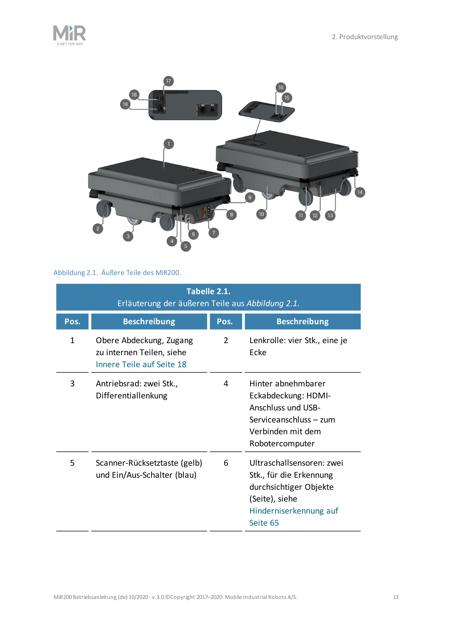
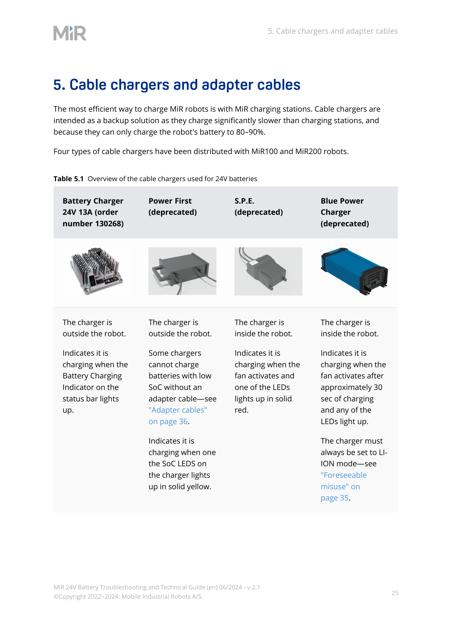
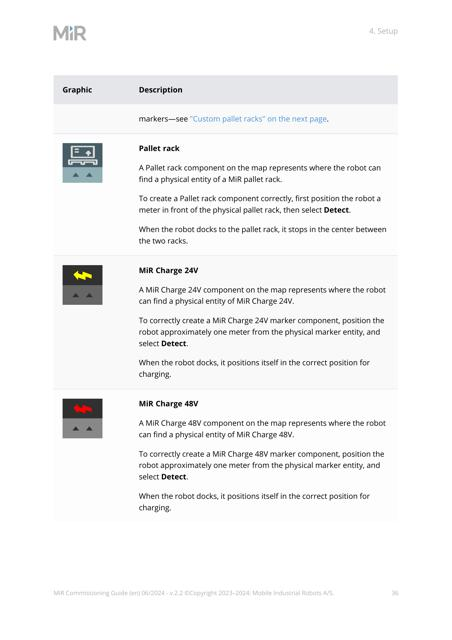
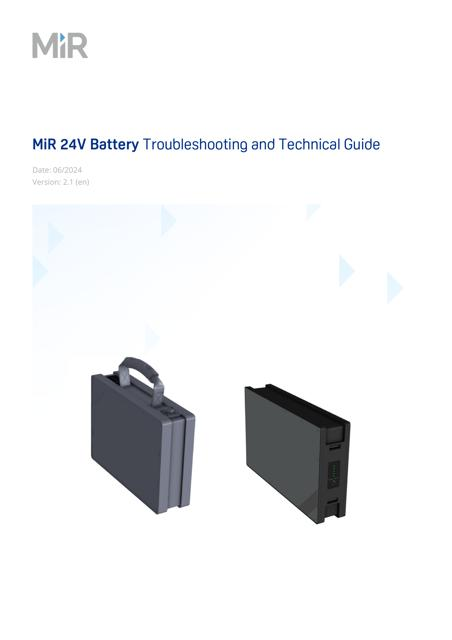
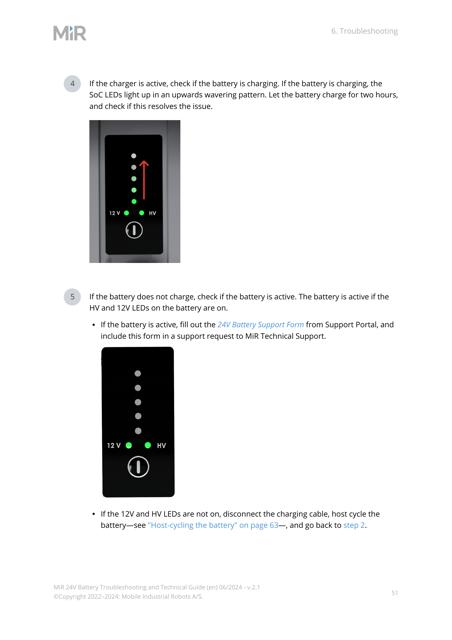
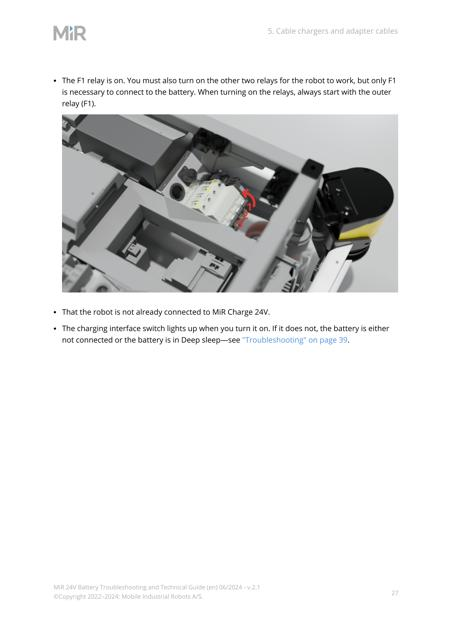

In [ ]:
engine_pages.inspect_run("Dense & Sparse(RRF)", 5)

Button(description='Next Query', style=ButtonStyle())


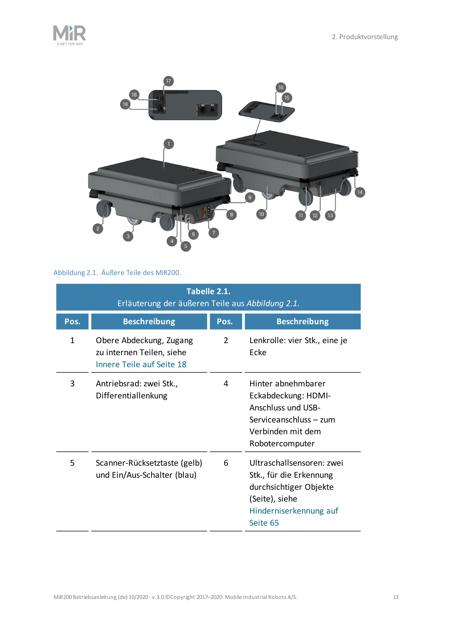
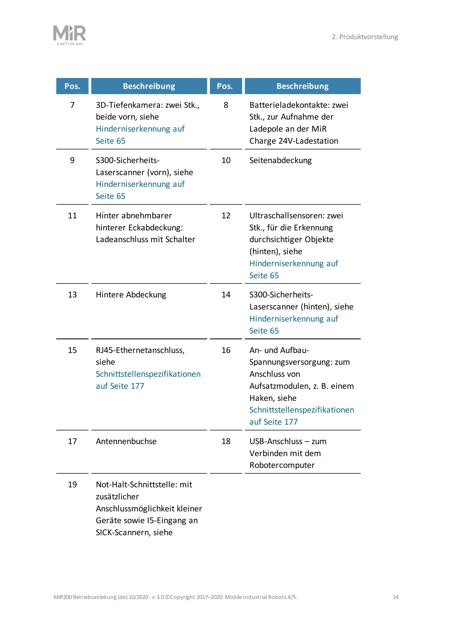
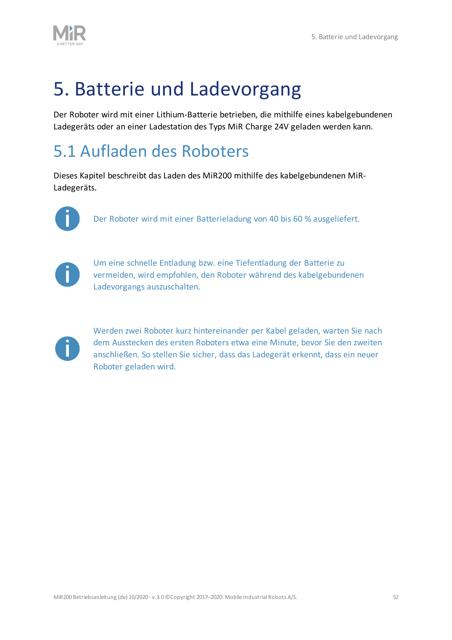
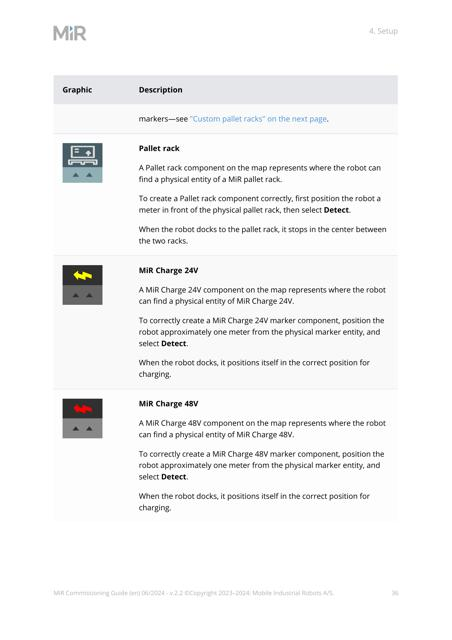
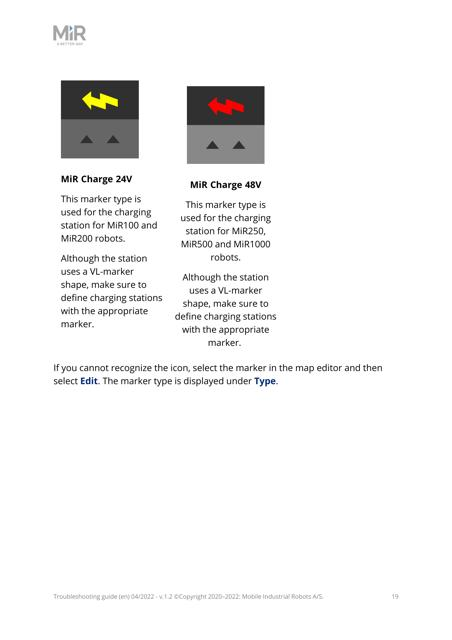
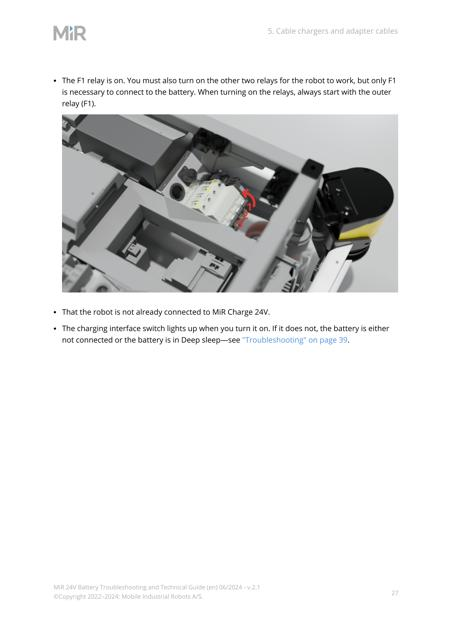

In [ ]:
engine_pages.inspect_run("Late Interaction")

## Showcasing for any user query and any retrieval pipeline (not at runtime)

In [ ]:
def display_results_for_query_multi(user_query):
    vectors = embed_single_query(user_query)
    qv = QueryVector(
                dense=vectors["dense_vector"],
                sparse=vectors["sparse_vector"],
                multi=vectors["multi_vector"],
                query_id=query_id
            )

    scores, payloads = engine_pages.basic_search(qv, "multi")
    display_result(user_query, payloads)


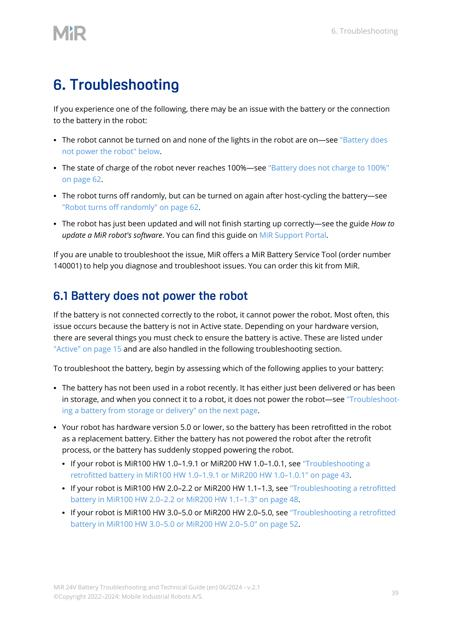
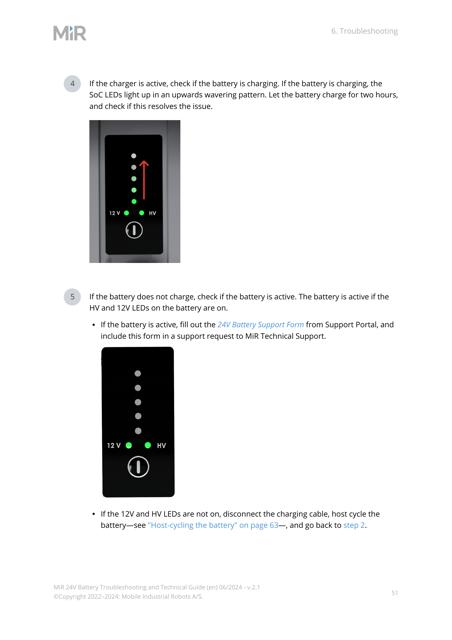
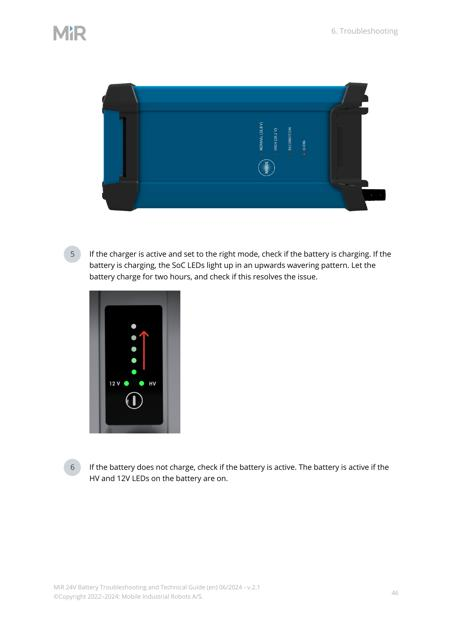
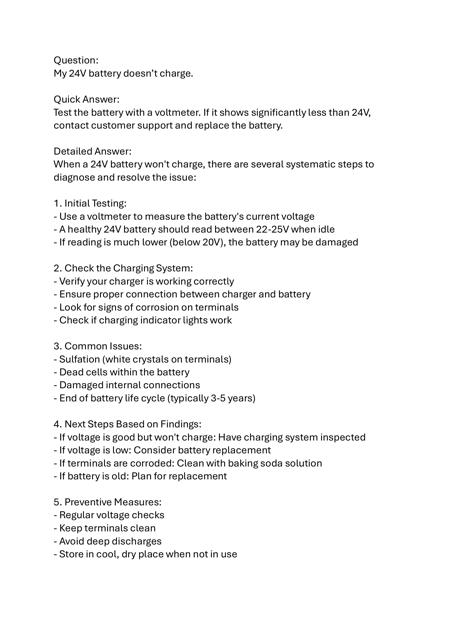
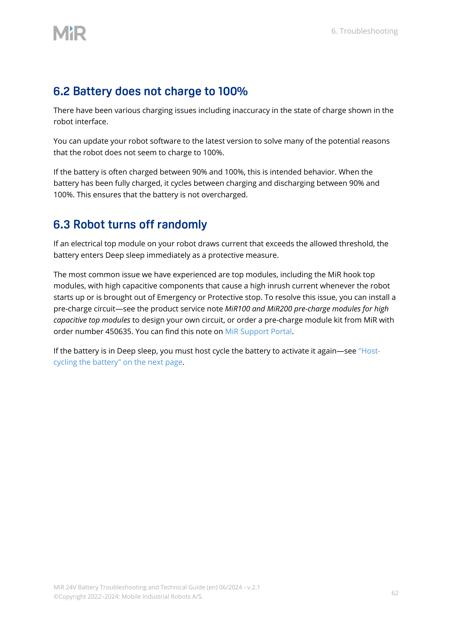

In [ ]:
display_results_for_query_multi("battery doesnt work")

In [ ]:
def display_results_for_query(user_query):
    vectors = embed_single_query(user_query)
    qv = QueryVector(
                dense=vectors["dense_vector"],
                sparse=vectors["sparse_vector"],
                multi=vectors["multi_vector"],
                query_id=query_id
            )

    scores, payloads = engine_pages.rrf_fusion_search(qv, ["dense", "sparse"])
    display_result(user_query, payloads)


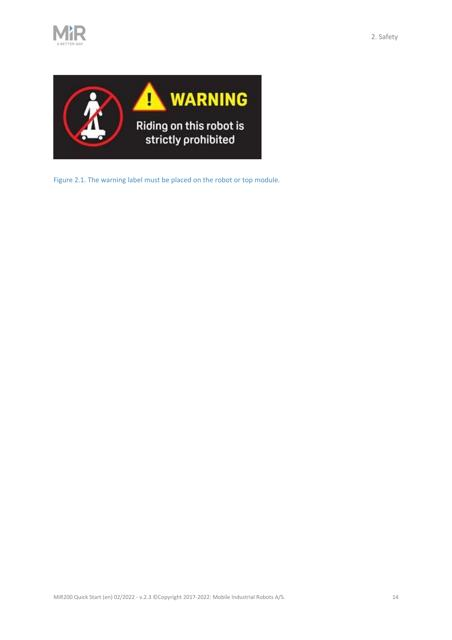
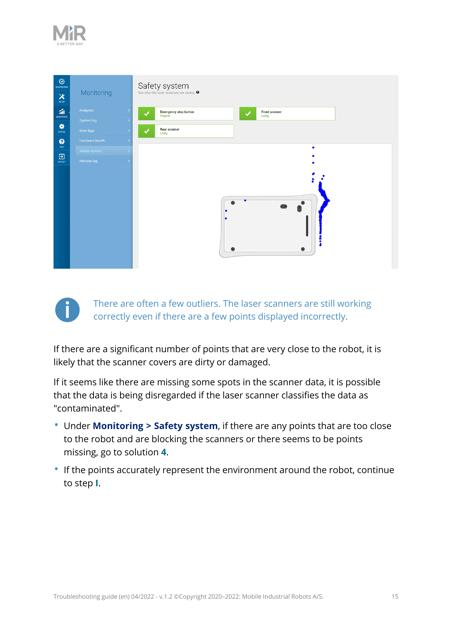
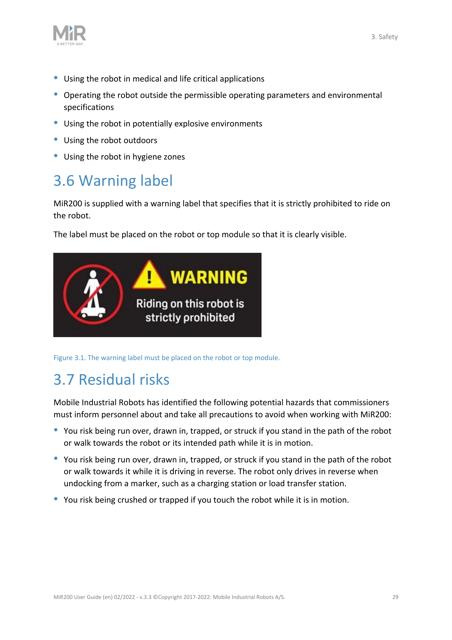
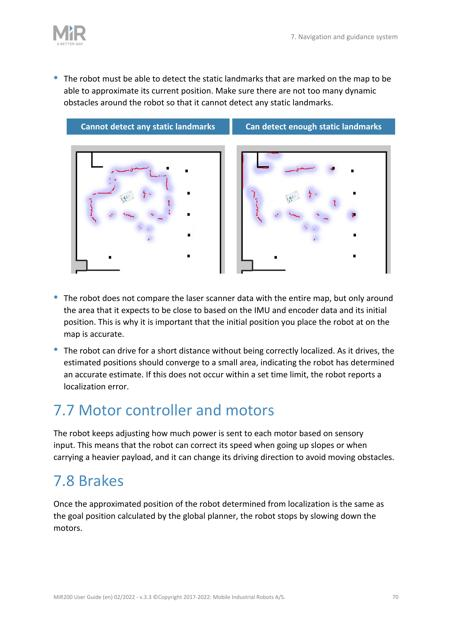
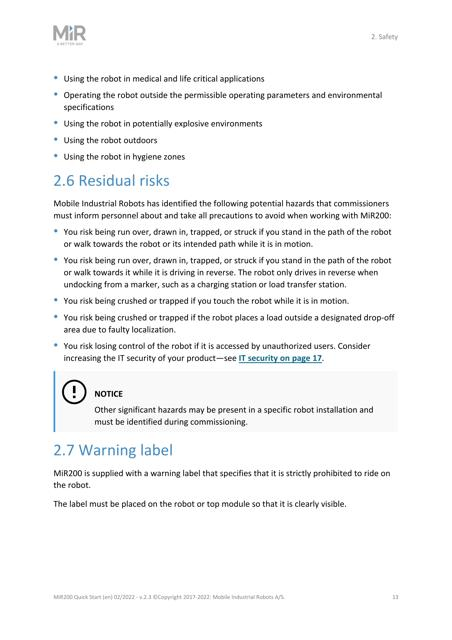

In [ ]:
display_results_for_query("Robot shows warning location accuracy low")


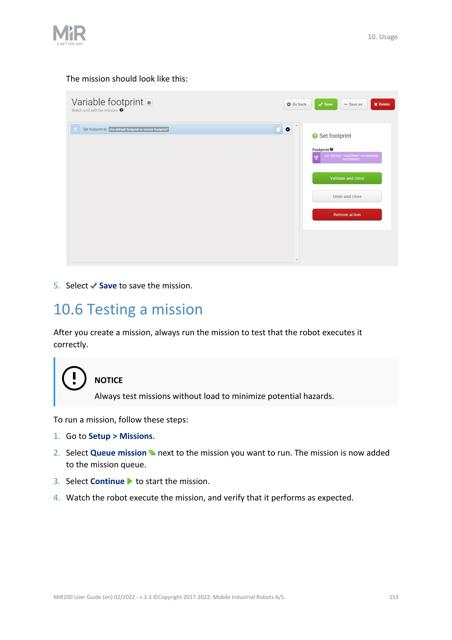
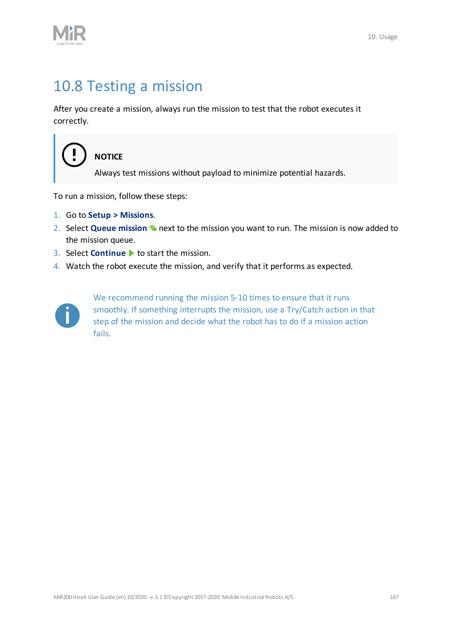
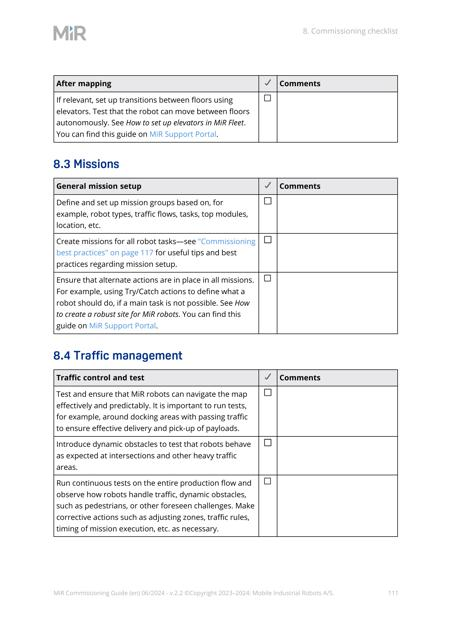
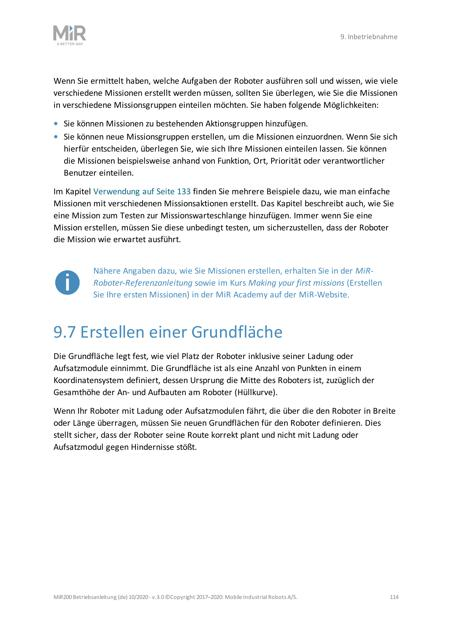
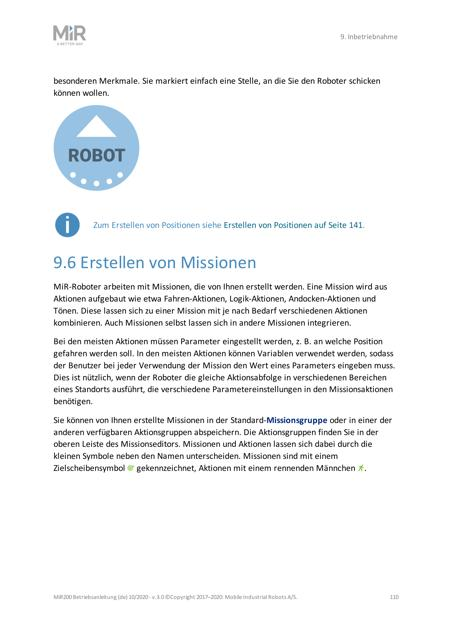

In [ ]:
display_results_for_query("I do not know how to setup a mission")


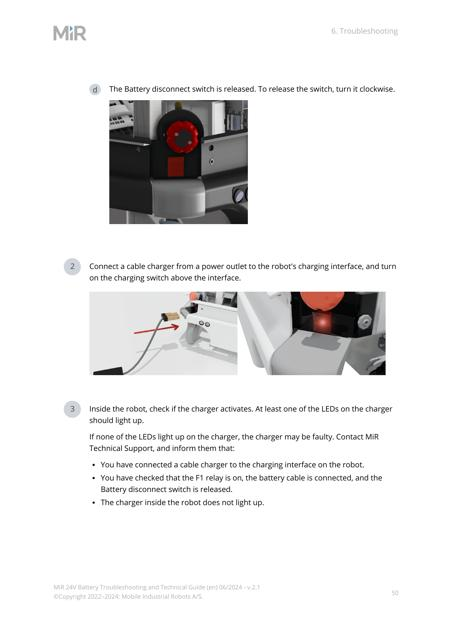
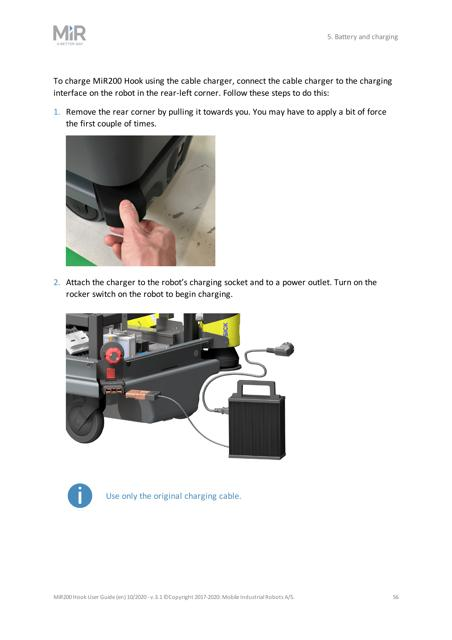
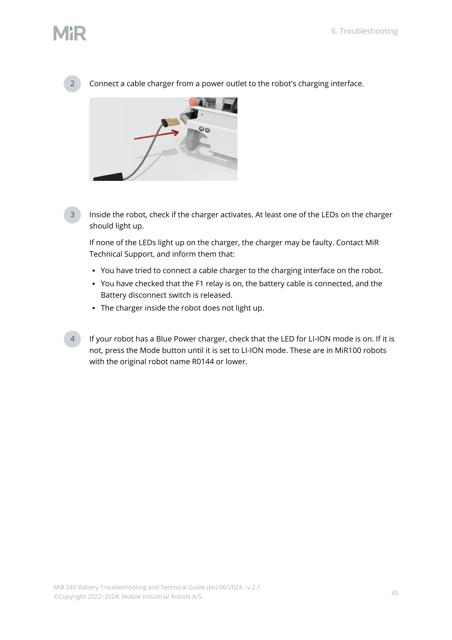
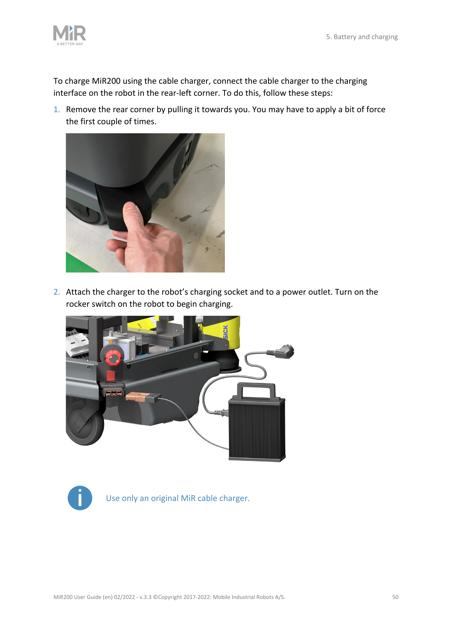
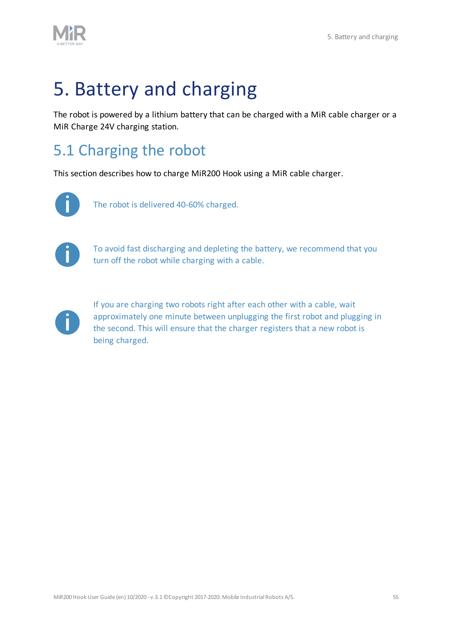

In [ ]:
display_results_for_query("Robot failed to charge")


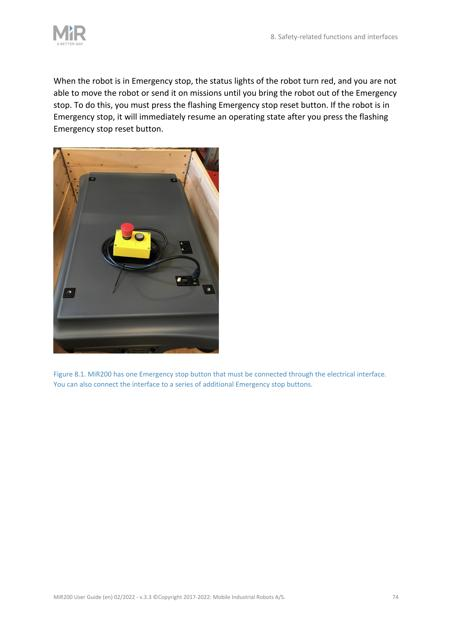
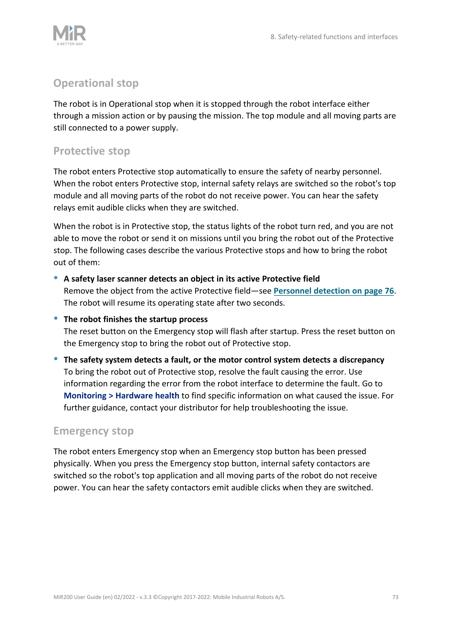
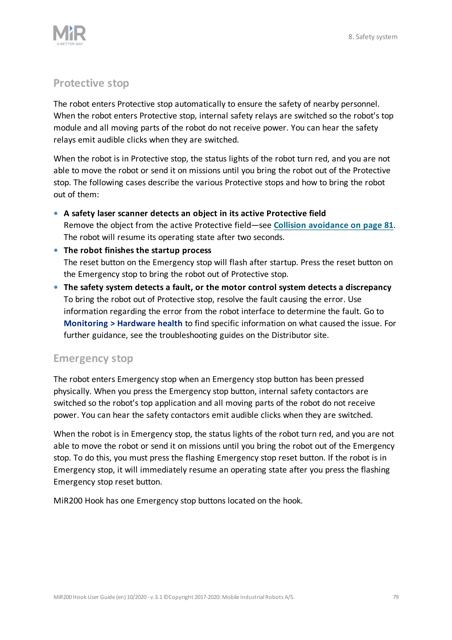
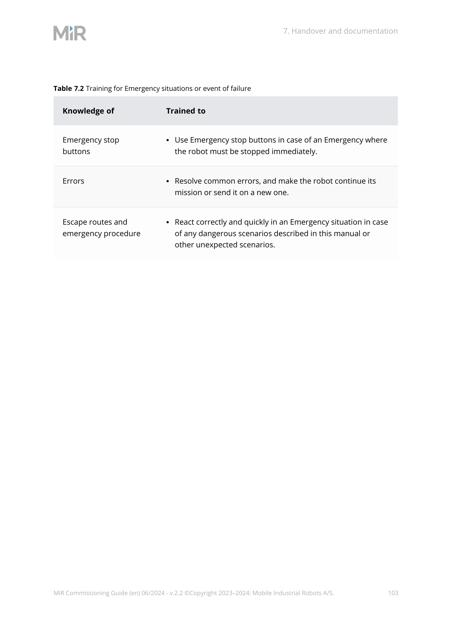
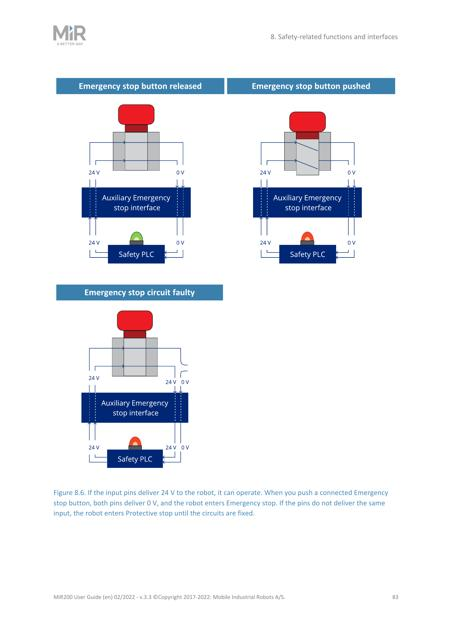

In [ ]:
display_results_for_query("Emergency stop active")


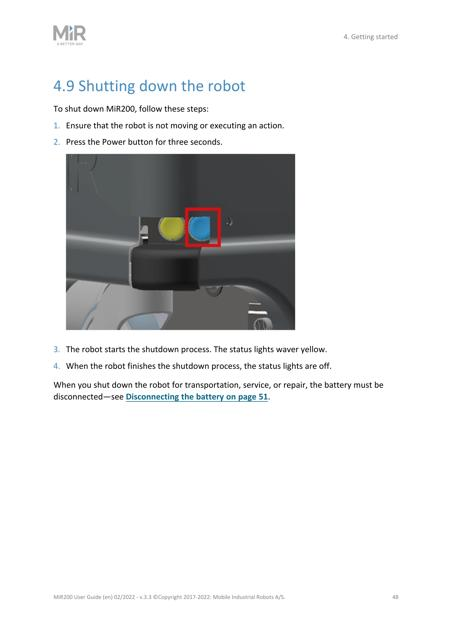
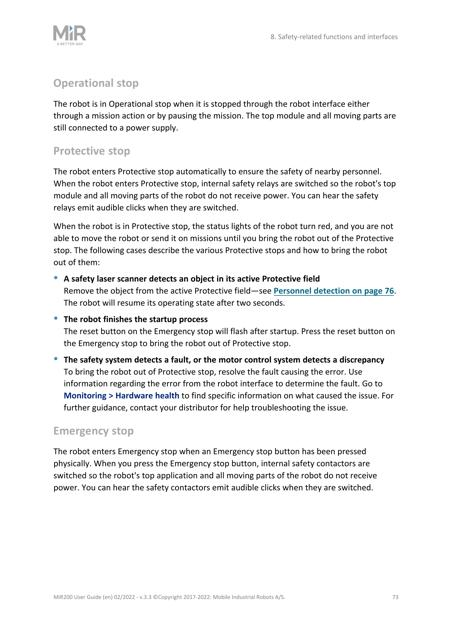
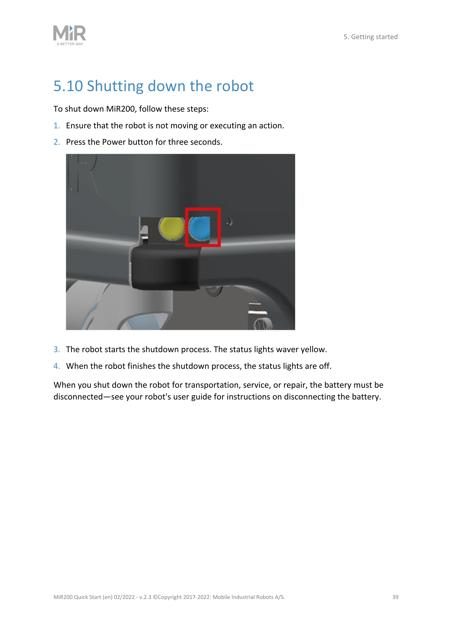
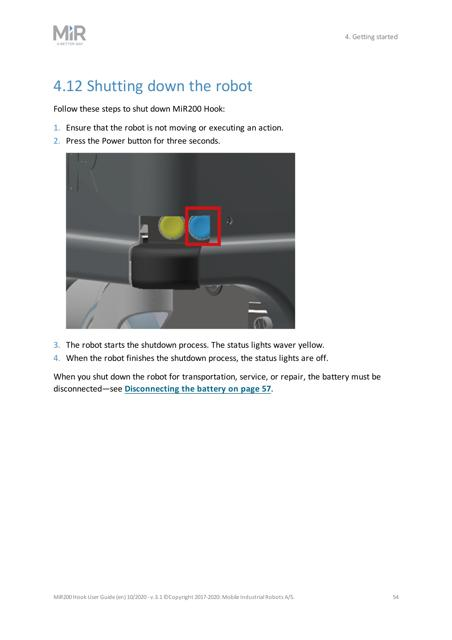
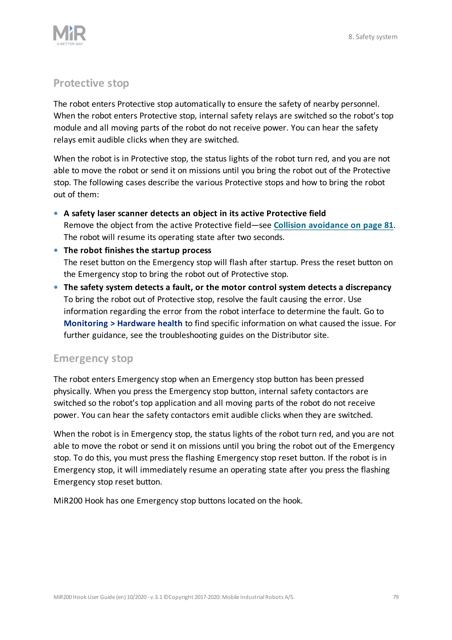

In [ ]:
display_results_for_query("Robot stopped and shut down")


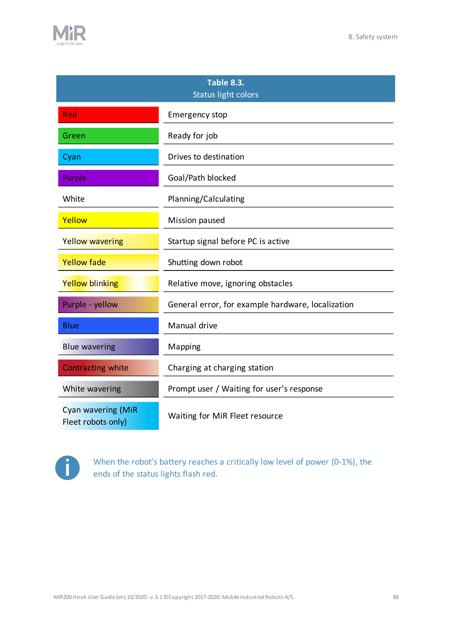
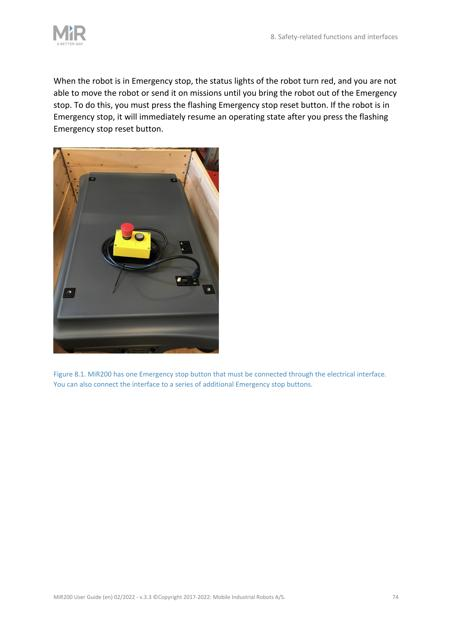
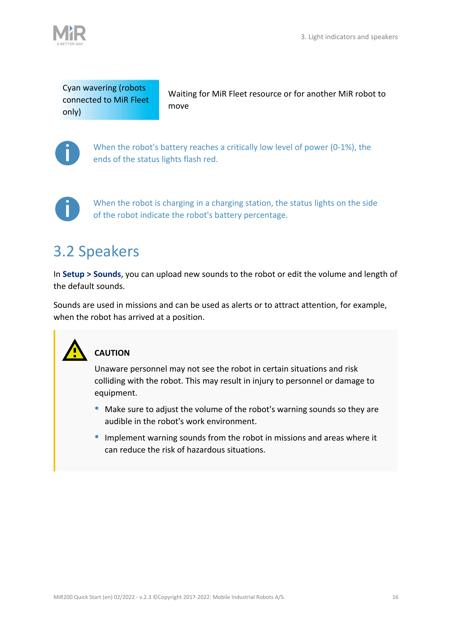
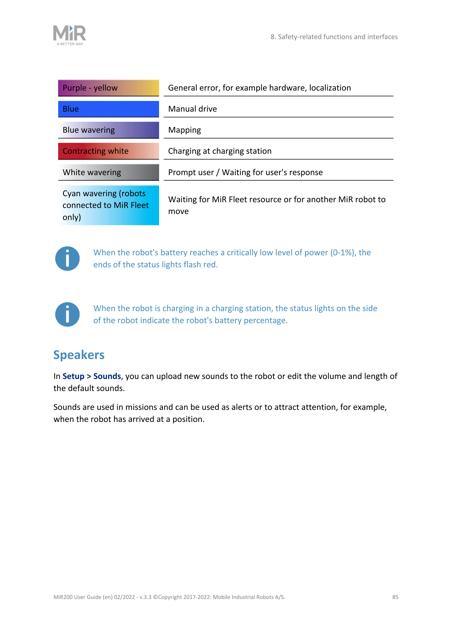
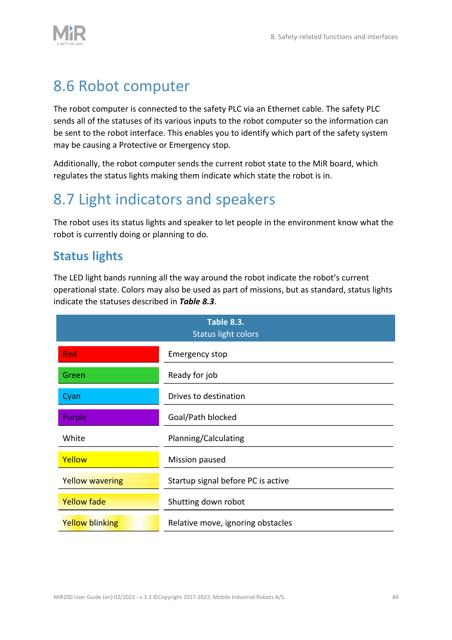

In [ ]:
display_results_for_query("Robot flashes in red")


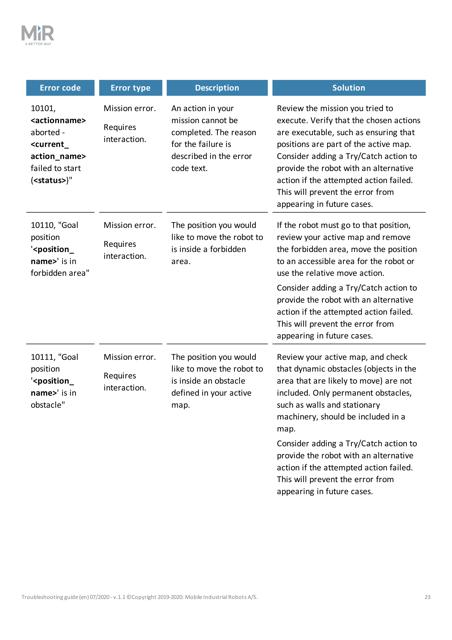
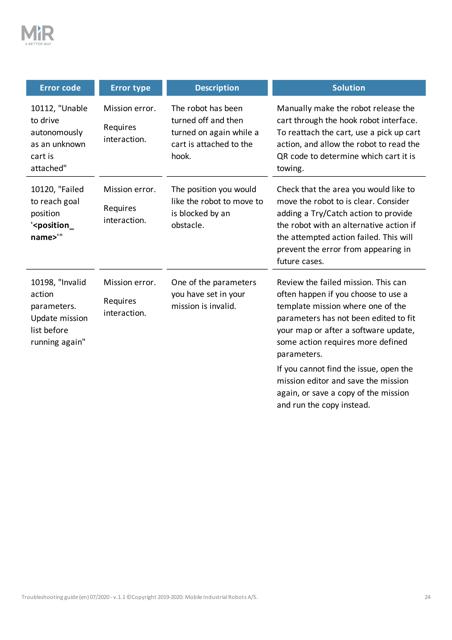
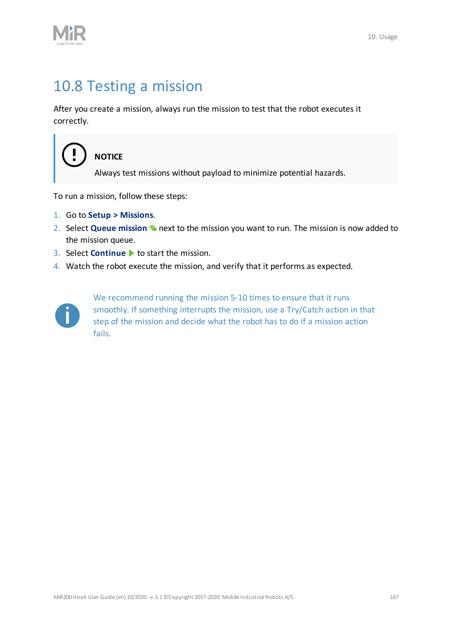
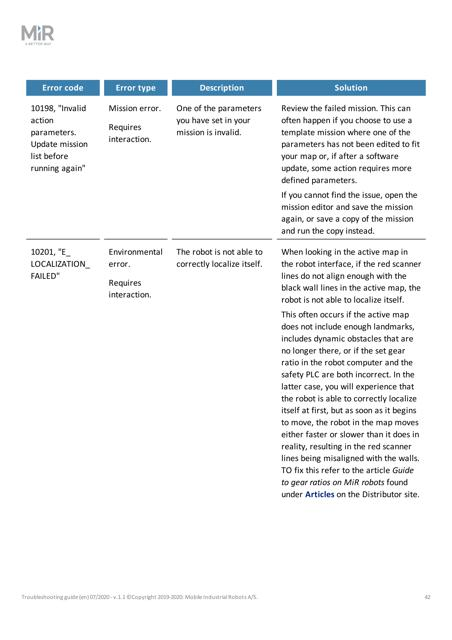
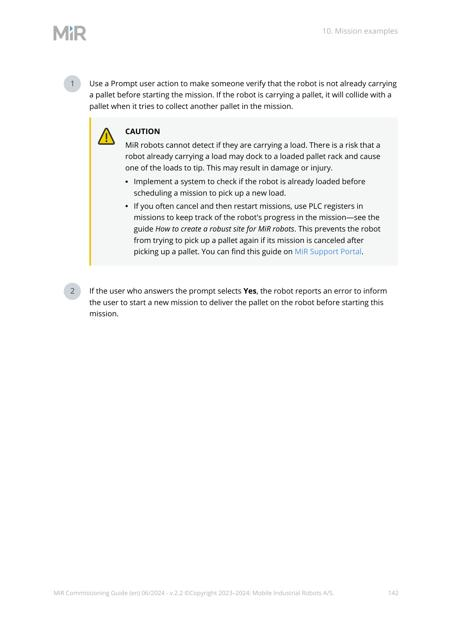

In [ ]:
display_results_for_query("Robot does not start the mission")